## Zego Data Science Telematics Technical Test
### Samuel Dolman, August 16th 2021

In [119]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

## Overview of Approach

* 37 trips are available - we will take **one observation for each labelled trip**
* an alternative would be to split each trip into e.g. minute long segments / 'sub-trips', and apply the same label to every sub-trip.
    * rejected this approach due to time constraints (if more time allowed, it would very likely be superior)
    * potential advantage: many more observations for training / test (although need to be careful to keep sub-trips from the same trip within the same validation split, to avoid leakage) - allows use of more powerful algorithms
    * potential disadvantage: no guarantee 'true' trip labels are consistent across entire trip - e.g. customer may walk first 2 minutes to the vehicle, then drive the remainder 
    * potential disadvantage: many sub-trips would not contain 'pulling away' and 'braking to a stop' manouvers - likely that these manuevers are important for achieving good classification accuracy
* binary classification task with a small/moderate amount of class imbalance - **Area Under Precision-Recall Curve** should be a good choice of performance metric (alternatives could be ROC_AuC / Accuracy / F1 Score, etc)
* ideal validation approach would be fixed **train / validate / test** sets, however not enough trips to do this (or even a standard 5-fold-CV) robustly. So, all results are presented as **out-of-fold AUC using leave-one-out CV**
* algorithm of choice will be a simple **logistic regression** (with **L1 and L2 elastic-net** penalties to minimise overfitting)
    * I would definitely prefer xgboost/lgbm/catboost classifier (or even just random forest), but decision to take one observation per trip is severely limiting
    * 1D Convolutional Neural Network - have seen these used succesfully so would investigate further if given time
    * ARIMA - often used for time domain problems so worth investigating. However I suspect they may not perform well - usually more useful for projection/extrapolation tasks rather than classification
* feature engineering*:
    * statistical
    * time based
    * spectral - split into segments, apply fourier transform to generate spectral, avg over all segments





\* Note that the feature engineering approach was partly inspired by two papers:

    Samuli Hemminki - https://www.cs.helsinki.fi/u/shemmink/Transportation/hemminki13transportation.pdf
    
    Nguyen, Linh Vuong - https://dspace.mit.edu/handle/1721.1/120606

## Load Data

In [2]:
# Location of 'trip_classes.csv' and individual 'trip_xx.csv' files:
data_location = 'data'
trip_location = 'data/trips'

In [3]:
trip_classes = pd.read_csv(os.path.join(data_location, 'trip_classes.csv'))

trips = {row['trip_id']: pd.read_csv(os.path.join(trip_location, row['trip_data'])) for index, row in trip_classes.iterrows()}

In [4]:
trip_classes.head()

,trip_type,trip_id,trip_data
0,car,0,trip_0.csv
1,walk_bicycle_still,1,trip_1.csv
2,car,2,trip_2.csv
3,car,3,trip_3.csv
4,car,4,trip_4.csv


In [448]:
trips[0].head()

,timestamp,ValueZ,ValueY,ValueX
0,1577895407245,-9.802161,-1.515576,-1.491633
1,1577895407266,-9.689631,-1.594587,-1.556279
2,1577895407286,-10.120600,-1.204320,-0.869122
3,1577895407307,-9.043176,-1.776552,-1.534730
4,1577895407328,-9.857229,-1.953728,-1.467690


## EDA

Some very simple exploratory analysis

Text(0.5, 1.0, 'Response Variable')

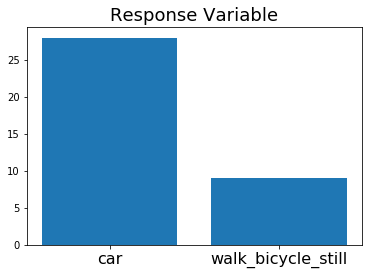

In [292]:
# Labels
label_counts = trip_classes['trip_type'].value_counts()
plt.bar(x = label_counts.index, height = label_counts)
plt.xticks(size=16)
plt.title('Response Variable', size = 18)

The majority of trips are by car

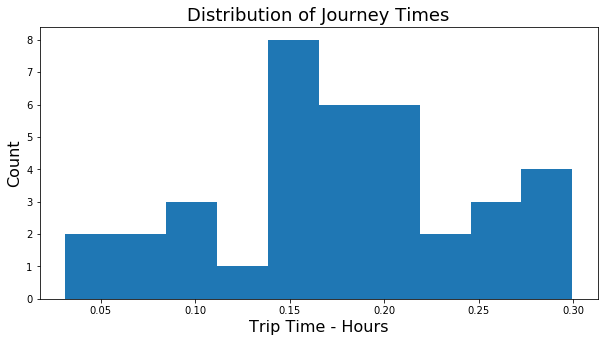

In [282]:
journey_times_in_hours = pd.Series([(trips[trip_id]['timestamp'].max() - trips[trip_id]['timestamp'].min())/(1000 * 60**2) \
                                      for trip_id in trips])

plt.figure(figsize=(10,5))
plt.hist(journey_times_in_hours)
plt.title('Distribution of Journey Times', size=18)
plt.xlabel('Trip Time - Hours', size = 16)
plt.ylabel('Count', size = 16)
plt.show()

Most trips are around 15-20 minutes in length - there is more we could do with timestamp information, but not explored here!

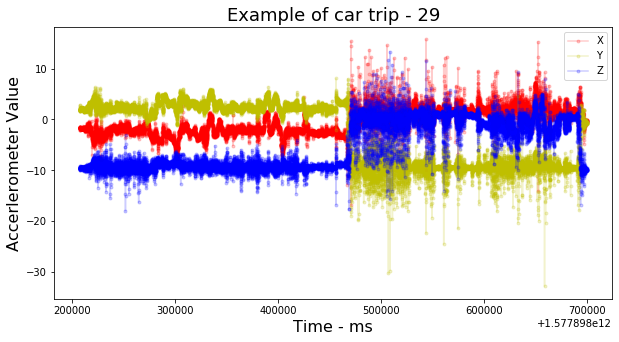

In [445]:
car_example = np.random.choice(trip_classes[trip_classes['trip_type'] == 'car']['trip_id'])
#car_example = 29
car_example_trip = trips[car_example]

plt.figure(figsize=(10,5))

plt.plot(car_example_trip['timestamp'], car_example_trip['ValueX'], '.r-', label = 'X', alpha = 0.2)
plt.plot(car_example_trip['timestamp'], car_example_trip['ValueY'], '.y-', label = 'Y', alpha = 0.2)
plt.plot(car_example_trip['timestamp'], car_example_trip['ValueZ'], '.b-', label = 'Z', alpha = 0.2)

plt.legend()
plt.title('Example of car trip - ' + str(car_example), size=18)
plt.xlabel('Time - ms', size = 16)
plt.ylabel('Accerlerometer Value', size = 16)
plt.show()

Example of X/Y/Z axis accelerometer readings over time. The discontinuity half-way through on trip 29 could be due to a mode change (e.g. from vehicle to walking), but note how the order of magnitude of the X/Y/Z acceleration values switches - this is likely to be when the smartphone was rotated to a different position (so that gravity is pulling in a different direction)

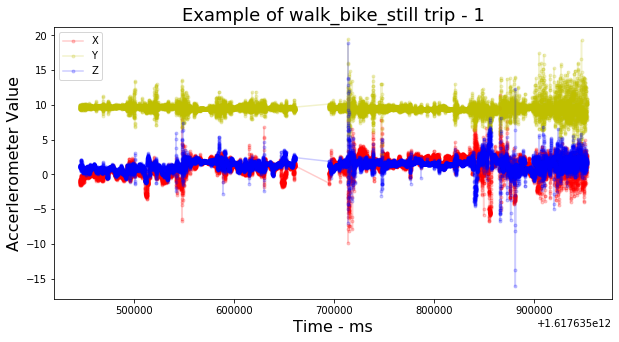

In [446]:
non_car_example = np.random.choice(trip_classes[trip_classes['trip_type'] != 'car']['trip_id'])
non_car_example_trip = trips[non_car_example]

plt.figure(figsize=(10,5))

plt.plot(non_car_example_trip['timestamp'], non_car_example_trip['ValueX'], '.r-', label = 'X', alpha = 0.2)
plt.plot(non_car_example_trip['timestamp'], non_car_example_trip['ValueY'], '.y-', label = 'Y', alpha = 0.2)
plt.plot(non_car_example_trip['timestamp'], non_car_example_trip['ValueZ'], '.b-', label = 'Z', alpha = 0.2)

plt.legend()
plt.title('Example of walk_bike_still trip - ' + str(non_car_example), size=18)
plt.xlabel('Time - ms', size = 16)
plt.ylabel('Accerlerometer Value', size = 16)
plt.show()

## Feature Engineering Process for a Single Trip

This function takes the raw accelerometer data for a single trip, and returns a single row of data containing all of our engineered features (ready to pass to the learning algorithm)

In [449]:
def process_single_trip(trip):
    
    # Impute Nulls
    trip.fillna(trip.median(), inplace = True)
    
    engineered_features = {}
    
    # Simple statistical Features:
    for col in ['ValueX', 'ValueY', 'ValueZ']:
        engineered_features[col + '_mean'] = trip[col].mean()
        engineered_features[col + '_std'] = trip[col].std()
        engineered_features[col + '_median'] = trip[col].median()
        engineered_features[col + '_skew'] = trip[col].skew()
        engineered_features[col + '_kurtosis'] = trip[col].kurt()
        engineered_features[col + '_99perc'] = trip[col].quantile(0.99)
        engineered_features[col + '_01perc'] = trip[col].quantile(0.1)
    
    
    # TODO: Spectral features:
    
    
    # TODO: Time/Event features:
    
    
    
    return engineered_features

In [ ]:
## normalise timestamps?

In [ ]:
trip = trips[0]

In [ ]:
## normalise out gravity direction?? e.g. do the rest on X/Y only?

In [ ]:
## spectral features
    ## moving timeframes (overlapping)
    ## calc spectral metrics for each timeframe
    ## summarise metrics across all timeframes

In [ ]:
## time based features (braking / accel events?)

## Process All Trips

In [25]:
# Creates dataframe with one row per trip, containing all feature engineered columns:
model_data = pd.DataFrame({trip_id: process_single_trip(trips[trip_id]) for trip_id in trips}).transpose()

# Join target label (convert to binary: 1 = car, 0 = non-car)
model_data['trip_type'] = 1 * (trip_classes['trip_type'] == 'car')

In [26]:
model_data.head()

,ValueX_mean,ValueX_std,ValueX_median,ValueX_skew,ValueX_kurtosis,ValueX_99perc,ValueX_01perc,ValueY_mean,ValueY_std,ValueY_median,...,ValueY_99perc,ValueY_01perc,ValueZ_mean,ValueZ_std,ValueZ_median,ValueZ_skew,ValueZ_kurtosis,ValueZ_99perc,ValueZ_01perc,trip_type
0,-3.080188,0.587436,-3.217905,0.760563,4.558682,-1.166012,-3.524373,-0.268410,0.706541,-0.270553,...,1.845986,-0.955316,-9.293600,0.642642,-9.253872,-0.181246,6.678691,-7.277279,-9.954197,1
1,1.108090,1.313009,1.272598,-0.904411,4.580400,3.772861,-0.368904,9.530668,0.753896,9.540592,...,12.327690,8.988435,1.358394,0.951934,1.431897,0.080300,25.567431,4.201915,0.426395,0
2,0.269154,3.051699,-0.584185,1.242606,1.648113,8.383058,-2.279280,0.355269,5.672269,3.258508,...,6.056612,-9.713276,-4.765938,6.417054,-8.602366,0.942961,-0.558623,9.526528,-10.108319,1
3,1.720673,3.458726,0.730254,0.044015,-0.840729,7.644919,-2.442160,-8.650238,1.976029,-9.093455,...,-4.744567,-10.561146,-2.050778,2.199540,-1.429382,-1.284155,28.865791,3.270963,-4.240261,1
4,-1.014070,1.584009,-1.256058,0.206662,45.742838,2.847396,-2.001052,4.389234,7.567511,8.413400,...,10.104608,-9.648508,3.668142,2.460158,4.595921,-1.007120,7.860901,7.707648,-0.084844,1


## Train Model

In [106]:
# We will use the following hyperparams for logistic regression:
lr_kwargs = {'penalty': 'elasticnet',
            'random_state': 42,
            'solver': 'saga',   # required for elastic net
            'C': 0.5,           # smaller = more regularisation applied
            'max_iter': 5000, 
            'verbose': 0,
            'l1_ratio': 0.1     # enet param: 0 is equivalent to L2 penalty, 1 is equiv to L1
            }

In [107]:
# Perform leave-one-out CV: train a model at each step and predict on the holdout row
out_of_fold_pred_probs = []
out_of_fold_preds = []

for index, row in model_data.iterrows():
    
    # Remove a single row:
    X_leave_one_out = model_data.drop(index).drop('trip_type', axis = 1)
    y_leave_one_out = model_data.drop(index)['trip_type']
    X_out_of_fold = row.drop('trip_type')
    
    # Fit a z-scaler (AFTER removing the single row, to avoid leakage)
    scaler = StandardScaler()
    scaler.fit(X_leave_one_out)

    # Apply z-scaler to both the in- and out-of-fold data
    X_leave_one_out[list(X_leave_one_out.columns)] = scaler.transform(X_leave_one_out)
    X_out_of_fold = scaler.transform(np.array(X_out_of_fold).reshape(1, -1))
    
    # Train our logistic regressor
    lr_leave_one_out = LogisticRegression(**lr_kwargs).fit(X_leave_one_out, y_leave_one_out)
    
    # Keep track of the out-of-fold predictions
    out_of_fold_pred_probs.append(lr_leave_one_out.predict_proba(np.array(X_out_of_fold).reshape(1,-1))[:,1][0])
    out_of_fold_preds.append(lr_leave_one_out.predict(np.array(X_out_of_fold).reshape(1,-1))[0])

print('Out-of-fold predictions:\n', np.round(np.array(out_of_fold_pred_probs), 4))

print('\nOut-of-fold predicted classes:\n', out_of_fold_preds)

Out-of-fold predictions:
 [0.8205 0.9915 0.8288 0.3982 0.8926 0.86   0.5027 0.1608 0.6981 0.9056
 0.9581 0.8836 0.9006 0.9909 0.8601 0.5557 0.9136 0.8289 0.7772 0.543
 0.6461 0.8386 0.9282 0.5445 0.6786 0.8068 0.7754 0.8393 0.8301 0.7944
 0.6556 0.7917 0.629  0.6975 0.9575 0.8169 0.9912]

Out-of-fold predicted classes:
 [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [108]:
# Now we take ALL the data to fit the final model:
X_full = model_data.drop('trip_type', axis = 1)
y_full = model_data['trip_type']

# Apply z-scaling:
scaler = StandardScaler()
scaler.fit(X_full)
X_full[list(X_full.columns)] = scaler.transform(X_full)

# Fit final model:
lr_final = LogisticRegression(**lr_kwargs).fit(X_full, y_full)

## Analysis

* Model performance metrics - train set (i.e. model with leakage!) vs. leave-one-out CV vs. random baseline 
* Which coefficients were the most useful? (we performed z-scaling, so coefficient magnitude approx. corresponds to feature importance)

In [243]:
# Confusion Matrix (final model)
#plot_confusion_matrix(lr_final, X_full, y_full)

In [244]:
# Confuson Matrix (leave-one-out CV)
conf_matrix = pd.DataFrame(confusion_matrix(y_true = y_full, y_pred = out_of_fold_preds))
conf_matrix.index = ['True Walk_Bike_Still','True Car']
conf_matrix.columns = ['Predicted Walk_Bike_Still','Predicted Car']
conf_matrix

,Predicted Walk_Bike_Still,Predicted Car
True Walk_Bike_Still,0,9
True Car,2,26


Confusion matrix is not all that helpful - threshold is set too low, so we rarely predict the minority class.

Better to look at precision vs recall curves:


Area Under Precision-Recall Curve (train set):  0.94757 
Area Under Precision-Recall Curve (leave-one-out CV):  0.72816 
Area Under Precision-Recall Curve (random baseline):  0.65153 



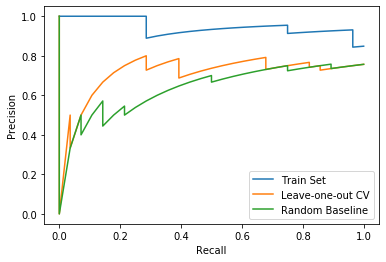

In [491]:
# Precision / Recall
full_model_training_preds = lr_final.predict_proba(X_full)[:,1]

np.random.seed(seed = 1)
random_baseline_preds = np.random.rand(y_full.shape[0])

precision_recall_full = precision_recall_curve(y_true = y_full, probas_pred = full_model_training_preds)
precision_recall_cv = precision_recall_curve(y_true = y_full, probas_pred = out_of_fold_pred_probs)
precision_recall_random = precision_recall_curve(y_true = y_full, probas_pred = random_baseline_preds)

plt.plot(precision_recall_full[1], precision_recall_full[0], label = 'Train Set')
plt.plot(precision_recall_cv[1], precision_recall_cv[0], label = 'Leave-one-out CV')
plt.plot(precision_recall_random[1], precision_recall_random[0], label = 'Random Baseline')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')

print('\nArea Under Precision-Recall Curve (train set): ',
      round(average_precision_score(y_true = y_full, y_score = full_model_training_preds), 5),
      '\nArea Under Precision-Recall Curve (leave-one-out CV): ',
      round(average_precision_score(y_true = y_full, y_score = out_of_fold_pred_probs), 5),
      '\nArea Under Precision-Recall Curve (random baseline): ',
      round(average_precision_score(y_true = y_full, y_score = random_baseline_preds), 5), '\n')

As expected (with such a small sample), comparison of train metrics to CV metrics shows evidence of overfitting. Happily we have beaten a random model, but not by much!

Clearly there is room for improvement :)

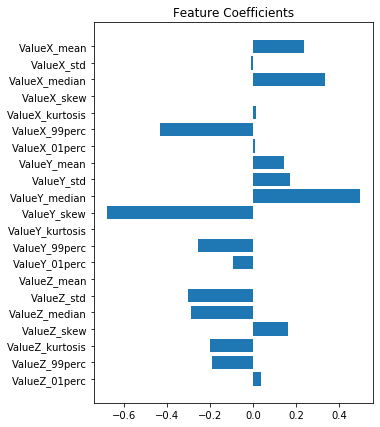

In [245]:
# Inspect the model Coefficients
coeffs = pd.DataFrame(zip(list(X_full.columns), lr_final.coef_[0]))

plt.figure(figsize=(5,7))
plt.barh(coeffs[0], coeffs[1])
plt.title('Feature Coefficients')
plt.gca().invert_yaxis()
plt.show()

It seems like the Y-axis skew and median values were most useful